# 注意力评分函数
:label:`sec_attention-scoring-functions`

 :numref:`sec_nadaraya-watson`使用了高斯核来对查询和键之间的关系建模。
 :eqref:`eq_nadaraya-watson-gaussian`中的
高斯核指数部分可以视为*注意力评分函数*（attention scoring function），
简称*评分函数*（scoring function），
然后把这个函数的输出结果输入到softmax函数中进行运算。
通过上述步骤，将得到与键对应的值的概率分布（即注意力权重）。
最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

从宏观来看，上述算法可以用来实现
 :numref:`fig_qkv`中的注意力机制框架。
 :numref:`fig_attention_output`说明了
如何将注意力汇聚的输出计算成为值的加权和，
其中$a$表示注意力评分函数。
由于注意力权重是概率分布，
因此加权和其本质上是加权平均值。

![计算注意力汇聚的输出为值的加权和](../img/attention-output.svg)
:label:`fig_attention_output`

用数学语言描述，假设有一个查询
$\mathbf{q} \in \mathbb{R}^q$和
$m$个“键－值”对
$(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)$，
其中$\mathbf{k}_i \in \mathbb{R}^k$，$\mathbf{v}_i \in \mathbb{R}^v$。
注意力汇聚函数$f$就被表示成值的加权和：

$$f(\mathbf{q}, (\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_m, \mathbf{v}_m)) = \sum_{i=1}^m \alpha(\mathbf{q}, \mathbf{k}_i) \mathbf{v}_i \in \mathbb{R}^v,$$
:eqlabel:`eq_attn-pooling`

其中查询$\mathbf{q}$和键$\mathbf{k}_i$的注意力权重（标量）
是通过注意力评分函数$a$将两个向量映射成标量，
再经过softmax运算得到的：

$$\alpha(\mathbf{q}, \mathbf{k}_i) = \mathrm{softmax}(a(\mathbf{q}, \mathbf{k}_i)) = \frac{\exp(a(\mathbf{q}, \mathbf{k}_i))}{\sum_{j=1}^m \exp(a(\mathbf{q}, \mathbf{k}_j))} \in \mathbb{R}.$$
:eqlabel:`eq_attn-scoring-alpha`

正如上图所示，选择不同的注意力评分函数$a$会导致不同的注意力汇聚操作。
本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。


In [1]:
import math
import torch
from torch import nn
# from d2l import torch as d2l

## [**掩蔽softmax操作**]

正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。
在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。
例如，为了在 :numref:`sec_machine_translation`中高效处理小批量数据集，
某些文本序列被填充了没有意义的特殊词元。
为了仅将有意义的词元作为值来获取注意力汇聚，
可以指定一个有效序列长度（即词元的个数），
以便在计算softmax时过滤掉超出指定范围的位置。
下面的`masked_softmax`函数
实现了这样的*掩蔽softmax操作*（masked softmax operation），
其中任何超出有效长度的位置都被掩蔽并置为0。


In [2]:
import torch

#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

In [3]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

为了[**演示此函数是如何工作**]的，
考虑由两个$2 \times 4$矩阵表示的样本，
这两个样本的有效长度分别为$2$和$3$。
经过掩蔽softmax操作，超出有效长度的值都被掩蔽为0。


In [4]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.6821, 0.3179, 0.0000, 0.0000],
         [0.6656, 0.3344, 0.0000, 0.0000]],

        [[0.3406, 0.2927, 0.3667, 0.0000],
         [0.2336, 0.4594, 0.3070, 0.0000]]])

同样，也可以使用二维张量，为矩阵样本中的每一行指定有效长度。


In [5]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2665, 0.2904, 0.4431, 0.0000]],

        [[0.5846, 0.4154, 0.0000, 0.0000],
         [0.2042, 0.3795, 0.2300, 0.1863]]])

## [**加性注意力**]
:label:`subsec_additive-attention`

一般来说，当查询和键是不同长度的矢量时，可以使用加性注意力作为评分函数。
给定查询$\mathbf{q} \in \mathbb{R}^q$和
键$\mathbf{k} \in \mathbb{R}^k$，
*加性注意力*（additive attention）的评分函数为

$$a(\mathbf q, \mathbf k) = \mathbf w_v^\top \text{tanh}(\mathbf W_q\mathbf q + \mathbf W_k \mathbf k) \in \mathbb{R},$$
:eqlabel:`eq_additive-attn`

其中可学习的参数是$\mathbf W_q\in\mathbb R^{h\times q}$、
$\mathbf W_k\in\mathbb R^{h\times k}$和
$\mathbf w_v\in\mathbb R^{h}$。
如 :eqref:`eq_additive-attn`所示，
将查询和键连结起来后输入到一个多层感知机（MLP）中，
感知机包含一个隐藏层，其隐藏单元数是一个超参数$h$。
通过使用$\tanh$作为激活函数，并且禁用偏置项。

下面来实现加性注意力。


In [6]:
#@save
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

用一个小例子来[**演示上面的`AdditiveAttention`类**]，
其中查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小），
实际输出为$(2,1,20)$、$(2,10,2)$和$(2,10,4)$。
注意力汇聚输出的形状为（批量大小，查询的步数，值的维度）。


In [10]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

尽管加性注意力包含了可学习的参数，但由于本例子中每个键都是相同的，
所以[**注意力权重**]是均匀的，由指定的有效长度决定。


In [11]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 设置高分辨率显示
    import matplotlib
    matplotlib.rcParams['figure.dpi'] = 100
    matplotlib.rcParams['savefig.dpi'] = 100
    
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                             sharex=True, sharey=True, squeeze=False)
    
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    
    fig.colorbar(pcm, ax=axes, shrink=0.6)
    plt.show()

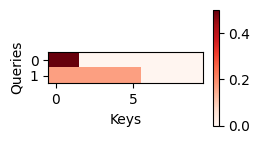

In [12]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## [**缩放点积注意力**]

使用点积可以得到计算效率更高的评分函数，
但是点积操作要求查询和键具有相同的长度$d$。
假设查询和键的所有元素都是独立的随机变量，
并且都满足零均值和单位方差，
那么两个向量的点积的均值为$0$，方差为$d$。
为确保无论向量长度如何，
点积的方差在不考虑向量长度的情况下仍然是$1$，
我们再将点积除以$\sqrt{d}$，
则*缩放点积注意力*（scaled dot-product attention）评分函数为：

$$a(\mathbf q, \mathbf k) = \mathbf{q}^\top \mathbf{k}  /\sqrt{d}.$$

在实践中，我们通常从小批量的角度来考虑提高效率，
例如基于$n$个查询和$m$个键－值对计算注意力，
其中查询和键的长度为$d$，值的长度为$v$。
查询$\mathbf Q\in\mathbb R^{n\times d}$、
键$\mathbf K\in\mathbb R^{m\times d}$和
值$\mathbf V\in\mathbb R^{m\times v}$的缩放点积注意力是：

$$ \mathrm{softmax}\left(\frac{\mathbf Q \mathbf K^\top }{\sqrt{d}}\right) \mathbf V \in \mathbb{R}^{n\times v}.$$
:eqlabel:`eq_softmax_QK_V`

下面的缩放点积注意力的实现使用了暂退法进行模型正则化。


In [13]:
#@save
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

为了[**演示上述的`DotProductAttention`类**]，
我们使用与先前加性注意力例子中相同的键、值和有效长度。
对于点积操作，我们令查询的特征维度与键的特征维度大小相同。


In [14]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

与加性注意力演示相同，由于键包含的是相同的元素，
而这些元素无法通过任何查询进行区分，因此获得了[**均匀的注意力权重**]。


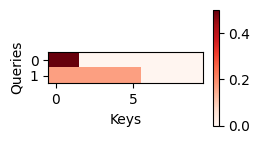

In [15]:
show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 小结

* 将注意力汇聚的输出计算可以作为值的加权平均，选择不同的注意力评分函数会带来不同的注意力汇聚操作。
* 当查询和键是不同长度的矢量时，可以使用可加性注意力评分函数。当它们的长度相同时，使用缩放的“点－积”注意力评分函数的计算效率更高。

## 练习

1. 修改小例子中的键，并且可视化注意力权重。可加性注意力和缩放的“点－积”注意力是否仍然产生相同的结果？为什么？
1. 只使用矩阵乘法，能否为具有不同矢量长度的查询和键设计新的评分函数？
1. 当查询和键具有相同的矢量长度时，矢量求和作为评分函数是否比“点－积”更好？为什么？


原始键矩阵示例 (全为1):
Keys shape: torch.Size([2, 10, 2])
Keys sample:
 tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.]])

修改后的键矩阵示例 (随机值):
Keys shape: torch.Size([2, 10, 2])
Keys sample:
 tensor([[-0.8371, -0.9224],
        [ 1.8113,  0.1606],
        [ 0.3672,  0.1754],
        [ 1.3852, -0.4459],
        [-1.2024,  0.7078],
        [-1.0759,  0.5357],
        [ 1.1754,  0.5612],
        [-0.4527, -0.7718],
        [ 0.1453,  0.2311],
        [ 0.0087, -0.1423]])

加性注意力输出:
tensor([[[ 2.4415,  3.4415,  4.4415,  5.4415]],

        [[10.2804, 11.2804, 12.2804, 13.2804]]], grad_fn=<BmmBackward0>)

缩放点积注意力输出:
tensor([[[ 2.8702,  3.8702,  4.8702,  5.8702]],

        [[ 8.5853,  9.5853, 10.5853, 11.5853]]])


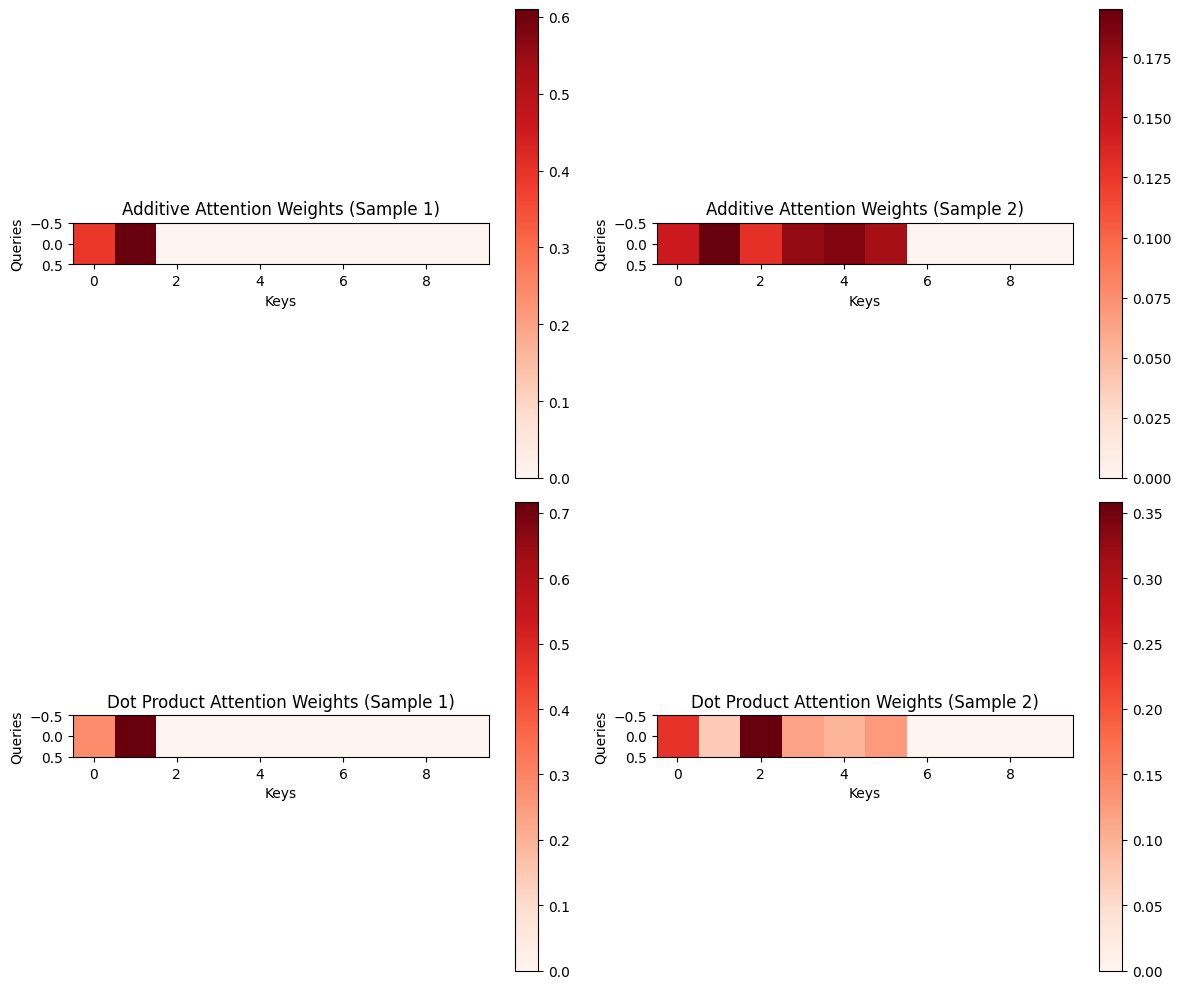


加性注意力权重 (第一个样本):
[[0.38962844 0.61037153 0.         0.         0.         0.
  0.         0.         0.         0.        ]]

缩放点积注意力权重 (第一个样本):
[[0.28244707 0.7175529  0.         0.         0.         0.
  0.         0.         0.         0.        ]]

加性注意力权重 (第二个样本):
[[0.14513093 0.19502066 0.12922327 0.17612801 0.18424645 0.17025065
  0.         0.         0.         0.        ]]

缩放点积注意力权重 (第二个样本):
[[0.23392814 0.07018012 0.35850403 0.11514107 0.09751993 0.12472656
  0.         0.         0.         0.        ]]


In [17]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt

# 定义必要的函数和类
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 创建修改后的键矩阵（使用不同的值而不是全1）
torch.manual_seed(42)  # 设置随机种子以确保结果可重现
queries, keys_original = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# 修改键矩阵，使用随机值而不是全1
keys_modified = torch.normal(0, 1, (2, 10, 2))
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

print("原始键矩阵示例 (全为1):")
print("Keys shape:", keys_original.shape)
print("Keys sample:\n", keys_original[0])

print("\n修改后的键矩阵示例 (随机值):")
print("Keys shape:", keys_modified.shape)
print("Keys sample:\n", keys_modified[0])

# 为了点积注意力，我们需要查询和键具有相同的维度
# 重新生成查询，使其与键的维度匹配
queries_dot = torch.normal(0, 1, (2, 1, 2))  # 与键的维度匹配

# 使用加性注意力 (可以处理不同维度的查询和键)
attention_add = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention_add.eval()
output_add = attention_add(queries, keys_modified, values, valid_lens)

# 使用缩放点积注意力 (需要查询和键具有相同维度)
attention_dot = DotProductAttention(dropout=0.1)
attention_dot.eval()
output_dot = attention_dot(queries_dot, keys_modified, values, valid_lens)

print("\n加性注意力输出:")
print(output_add)
print("\n缩放点积注意力输出:")
print(output_dot)

# 可视化注意力权重
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 加性注意力权重
add_weights = attention_add.attention_weights.reshape(2, 1, 10)
im1 = axes[0, 0].imshow(add_weights[0].detach().numpy(), cmap='Reds')
axes[0, 0].set_title('Additive Attention Weights (Sample 1)')
axes[0, 0].set_xlabel('Keys')
axes[0, 0].set_ylabel('Queries')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(add_weights[1].detach().numpy(), cmap='Reds')
axes[0, 1].set_title('Additive Attention Weights (Sample 2)')
axes[0, 1].set_xlabel('Keys')
axes[0, 1].set_ylabel('Queries')
plt.colorbar(im2, ax=axes[0, 1])

# 缩放点积注意力权重
dot_weights = attention_dot.attention_weights.reshape(2, 1, 10)
im3 = axes[1, 0].imshow(dot_weights[0].detach().numpy(), cmap='Reds')
axes[1, 0].set_title('Dot Product Attention Weights (Sample 1)')
axes[1, 0].set_xlabel('Keys')
axes[1, 0].set_ylabel('Queries')
plt.colorbar(im3, ax=axes[1, 0])

im4 = axes[1, 1].imshow(dot_weights[1].detach().numpy(), cmap='Reds')
axes[1, 1].set_title('Dot Product Attention Weights (Sample 2)')
axes[1, 1].set_xlabel('Keys')
axes[1, 1].set_ylabel('Queries')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# 打印数值结果进行比较
print("\n加性注意力权重 (第一个样本):")
print(add_weights[0].detach().numpy())
print("\n缩放点积注意力权重 (第一个样本):")
print(dot_weights[0].detach().numpy())

print("\n加性注意力权重 (第二个样本):")
print(add_weights[1].detach().numpy())
print("\n缩放点积注意力权重 (第二个样本):")
print(dot_weights[1].detach().numpy())

查询维度: torch.Size([2, 3, 4])
键维度: torch.Size([2, 5, 4])
值维度: torch.Size([2, 5, 8])

=== 点积注意力 ===
输出维度: torch.Size([2, 3, 8])
注意力权重维度: torch.Size([2, 3, 5])
注意力权重 (第一个样本):
tensor([[0.5507, 0.4453, 0.0040, 0.0000, 0.0000],
        [0.5220, 0.4590, 0.0190, 0.0000, 0.0000],
        [0.2170, 0.4914, 0.2916, 0.0000, 0.0000]])

=== 向量求和注意力 ===
输出维度: torch.Size([2, 3, 8])
注意力权重维度: torch.Size([2, 3, 5])
注意力权重 (第一个样本):
tensor([[0.4853, 0.4531, 0.0616, 0.0000, 0.0000],
        [0.4810, 0.4580, 0.0611, 0.0000, 0.0000],
        [0.1294, 0.3358, 0.5348, 0.0000, 0.0000]])

=== 加权向量求和注意力 ===
输出维度: torch.Size([2, 3, 8])
注意力权重维度: torch.Size([2, 3, 5])
注意力权重 (第一个样本):
tensor([[0.4853, 0.4531, 0.0616, 0.0000, 0.0000],
        [0.4810, 0.4580, 0.0611, 0.0000, 0.0000],
        [0.1294, 0.3358, 0.5348, 0.0000, 0.0000]], grad_fn=<SelectBackward0>)


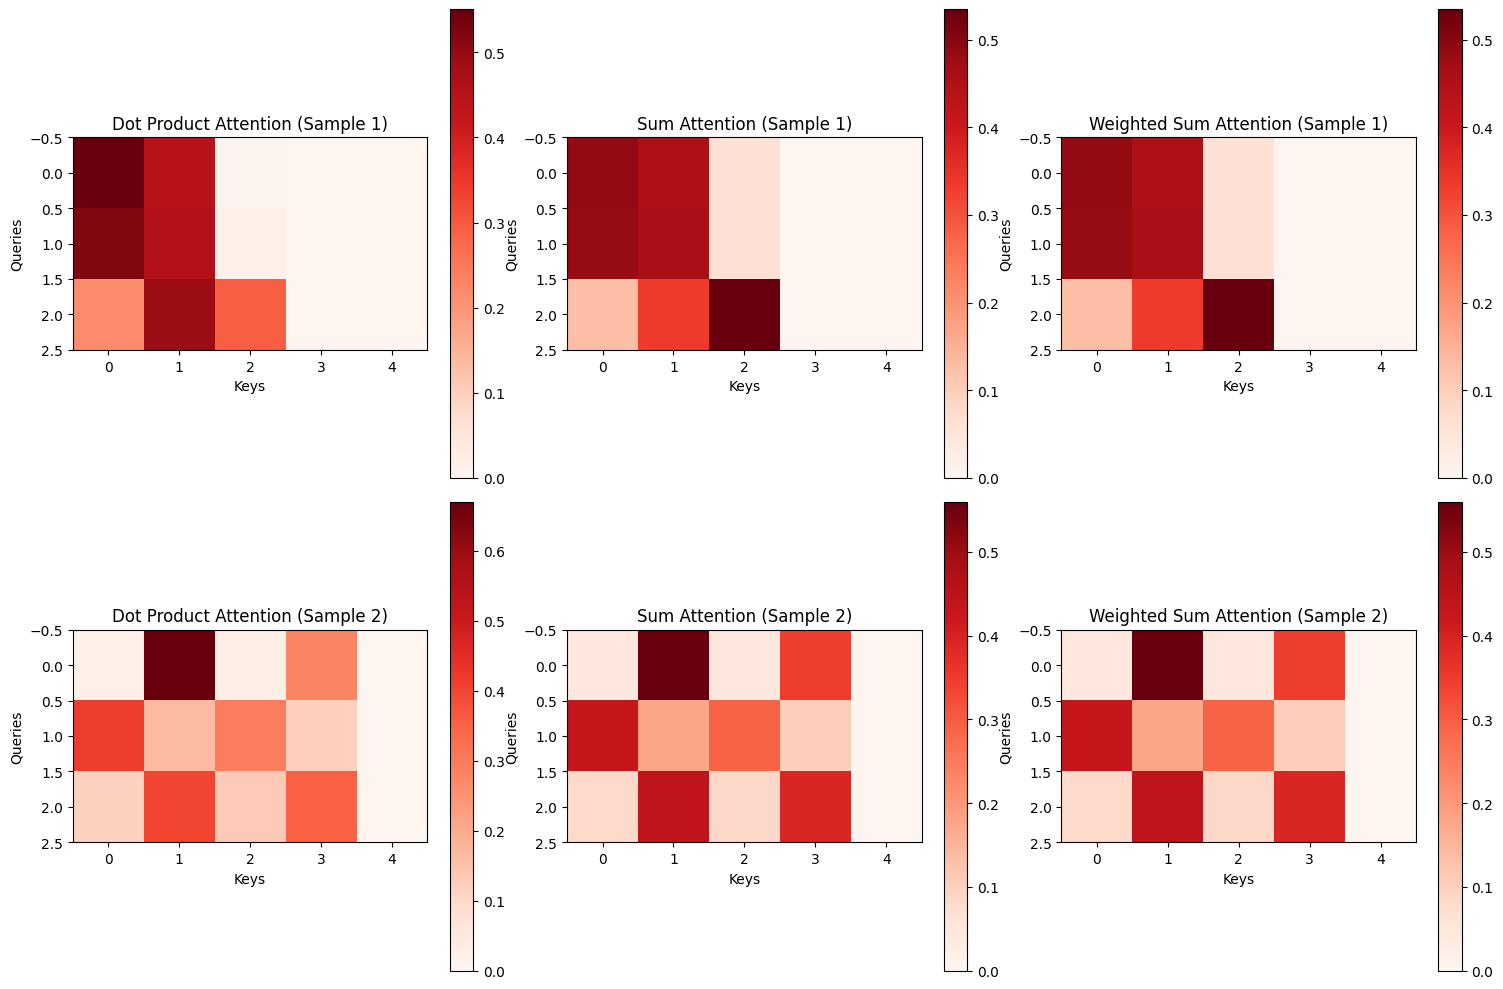


=== 输出比较 (第一个样本的第一个查询) ===
点积注意力输出:
tensor([ 3.6262,  4.6262,  5.6262,  6.6262,  7.6262,  8.6262,  9.6262, 10.6262])

向量求和注意力输出:
tensor([ 4.6106,  5.6106,  6.6106,  7.6106,  8.6106,  9.6106, 10.6106, 11.6106])

加权向量求和注意力输出:
tensor([ 4.6106,  5.6106,  6.6106,  7.6106,  8.6106,  9.6106, 10.6106, 11.6106],
       grad_fn=<SelectBackward0>)


In [19]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt

# 定义必要的函数
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                          value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class SumAttention(nn.Module):
    """向量求和注意力"""
    def __init__(self, dropout, **kwargs):
        super(SumAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        # 添加可学习的权重矩阵来增加表达能力
        self.W = nn.Parameter(torch.randn(1, 1, 1))

    def forward(self, queries, keys, values, valid_lens=None):
        # 计算查询和键的和
        # queries: (batch_size, num_queries, d)
        # keys: (batch_size, num_keys, d)
        # 为了计算所有查询和所有键的组合，我们需要扩展维度
        # queries_expanded: (batch_size, num_queries, 1, d)
        # keys_expanded: (batch_size, 1, num_keys, d)
        queries_expanded = queries.unsqueeze(2)
        keys_expanded = keys.unsqueeze(1)
        
        # 计算和
        sum_scores = queries_expanded + keys_expanded
        # 取和的L2范数作为评分
        scores = torch.norm(sum_scores, dim=-1)
        
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class WeightedSumAttention(nn.Module):
    """加权向量求和注意力"""
    def __init__(self, dim, dropout, **kwargs):
        super(WeightedSumAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        # 为每个维度添加可学习权重
        self.weight = nn.Parameter(torch.ones(dim))

    def forward(self, queries, keys, values, valid_lens=None):
        # 应用权重到查询和键
        weighted_queries = queries * self.weight
        weighted_keys = keys * self.weight
        
        # 计算加权和
        queries_expanded = weighted_queries.unsqueeze(2)
        keys_expanded = weighted_keys.unsqueeze(1)
        sum_scores = queries_expanded + keys_expanded
        # 取和的L2范数作为评分
        scores = torch.norm(sum_scores, dim=-1)
        
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

# 创建测试数据
torch.manual_seed(42)

# 使用相同维度的查询和键
queries = torch.normal(0, 1, (2, 3, 4))  # batch_size=2, num_queries=3, dim=4
keys = torch.normal(0, 1, (2, 5, 4))     # batch_size=2, num_keys=5, dim=4
values = torch.arange(40, dtype=torch.float32).reshape(1, 5, 8).repeat(2, 1, 1)  # batch_size=2, num_keys=5, value_dim=8
valid_lens = torch.tensor([3, 4])  # 有效长度

print("查询维度:", queries.shape)
print("键维度:", keys.shape)
print("值维度:", values.shape)

# 点积注意力
print("\n=== 点积注意力 ===")
dot_attention = DotProductAttention(dropout=0.1)
dot_attention.eval()
dot_output = dot_attention(queries, keys, values, valid_lens)
print("输出维度:", dot_output.shape)
print("注意力权重维度:", dot_attention.attention_weights.shape)
print("注意力权重 (第一个样本):")
print(dot_attention.attention_weights[0])

# 向量求和注意力
print("\n=== 向量求和注意力 ===")
sum_attention = SumAttention(dropout=0.1)
sum_attention.eval()
sum_output = sum_attention(queries, keys, values, valid_lens)
print("输出维度:", sum_output.shape)
print("注意力权重维度:", sum_attention.attention_weights.shape)
print("注意力权重 (第一个样本):")
print(sum_attention.attention_weights[0])

# 加权向量求和注意力
print("\n=== 加权向量求和注意力 ===")
weighted_sum_attention = WeightedSumAttention(dim=4, dropout=0.1)
weighted_sum_attention.eval()
weighted_sum_output = weighted_sum_attention(queries, keys, values, valid_lens)
print("输出维度:", weighted_sum_output.shape)
print("注意力权重维度:", weighted_sum_attention.attention_weights.shape)
print("注意力权重 (第一个样本):")
print(weighted_sum_attention.attention_weights[0])

# 可视化注意力权重
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 点积注意力权重
im1 = axes[0, 0].imshow(dot_attention.attention_weights[0].detach().numpy(), cmap='Reds')
axes[0, 0].set_title('Dot Product Attention (Sample 1)')
axes[0, 0].set_xlabel('Keys')
axes[0, 0].set_ylabel('Queries')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[1, 0].imshow(dot_attention.attention_weights[1].detach().numpy(), cmap='Reds')
axes[1, 0].set_title('Dot Product Attention (Sample 2)')
axes[1, 0].set_xlabel('Keys')
axes[1, 0].set_ylabel('Queries')
plt.colorbar(im2, ax=axes[1, 0])

# 向量求和注意力权重
im3 = axes[0, 1].imshow(sum_attention.attention_weights[0].detach().numpy(), cmap='Reds')
axes[0, 1].set_title('Sum Attention (Sample 1)')
axes[0, 1].set_xlabel('Keys')
axes[0, 1].set_ylabel('Queries')
plt.colorbar(im3, ax=axes[0, 1])

im4 = axes[1, 1].imshow(sum_attention.attention_weights[1].detach().numpy(), cmap='Reds')
axes[1, 1].set_title('Sum Attention (Sample 2)')
axes[1, 1].set_xlabel('Keys')
axes[1, 1].set_ylabel('Queries')
plt.colorbar(im4, ax=axes[1, 1])

# 加权向量求和注意力权重
im5 = axes[0, 2].imshow(weighted_sum_attention.attention_weights[0].detach().numpy(), cmap='Reds')
axes[0, 2].set_title('Weighted Sum Attention (Sample 1)')
axes[0, 2].set_xlabel('Keys')
axes[0, 2].set_ylabel('Queries')
plt.colorbar(im5, ax=axes[0, 2])

im6 = axes[1, 2].imshow(weighted_sum_attention.attention_weights[1].detach().numpy(), cmap='Reds')
axes[1, 2].set_title('Weighted Sum Attention (Sample 2)')
axes[1, 2].set_xlabel('Keys')
axes[1, 2].set_ylabel('Queries')
plt.colorbar(im6, ax=axes[1, 2])

plt.tight_layout()
plt.show()

# 比较三种方法的输出
print("\n=== 输出比较 (第一个样本的第一个查询) ===")
print("点积注意力输出:")
print(dot_output[0, 0])
print("\n向量求和注意力输出:")
print(sum_output[0, 0])
print("\n加权向量求和注意力输出:")
print(weighted_sum_output[0, 0])

[Discussions](https://discuss.d2l.ai/t/5752)
